In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# input spectra file name, the file is directly taken from Nirvana
filename = '2020-09-30T22_37(41)_costar white.txt'

# import spectra file as panda dataframe
df = pd.read_csv('PL/'+filename, sep = '\t')

# transpose the dataframe so that index is vial ID and column is wavelength
PL = df.transpose()
columns = np.array(PL.loc['Wavelength'], dtype='int32')
PL = pd.DataFrame(data = np.array(PL.drop(['Wavelength'])), columns = columns, index = PL.drop(['Wavelength']).index)

# Process the spectra
PL_bs = PL.subtract(PL.min(axis=1),axis = 0) # substract the baseline
PL_norm = PL_bs.div(PL_bs.max(axis=1), axis = 0) # normalize the spectra

# Smooth UV_norm data with Savitzky-Golay
from scipy.signal import savgol_filter
PL_norm_sm = pd.DataFrame(columns = PL_norm.columns)
for i in PL_norm.index:
    PL_norm_sm.loc[i] = savgol_filter(PL_norm.loc[i], window_length = 101, polyorder = 2, delta=1)
    
from scipy.signal import find_peaks
PL_peak_lst = {} # the wavelength of the peak
for idx in PL_norm_sm.index:
    peak,_ = find_peaks(np.array(PL_norm_sm.loc[idx]), prominence=0.02)
    if peak.size == 0:
        PL_peak_lst[idx] = 0
    else:
        PL_peak_lst[idx] = PL_norm_sm.columns[peak[-1]]
    
PL_peak = pd.DataFrame(data = np.array(list(PL_peak_lst.values())).reshape(-1,1), index = PL_peak_lst.keys(), columns = ['PL peak'])


# Save all processed spectra to csv files
(PL.T).to_csv('PL/'+filename[:-4]+'_original.csv')
(PL_bs.T).to_csv('PL/'+filename[:-4]+'_bs.csv')
(PL_norm.T).to_csv('PL/'+filename[:-4]+'_norm.csv')
(PL_norm_sm.T).to_csv('PL/'+filename[:-4]+'_norm_sm.csv')
(PL_peak).to_csv('PL/'+filename[:-4]+'_PL_peaks.csv')

<IPython.core.display.Javascript object>


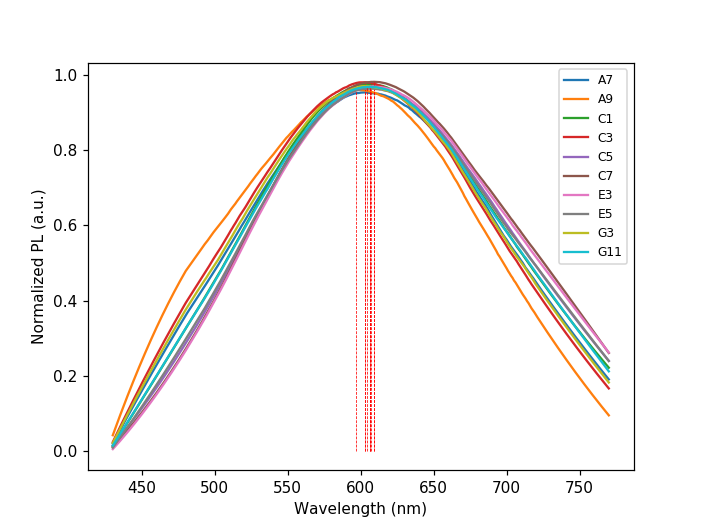

In [21]:
PL_plot = PL_norm_sm.drop(['E1','A5','A11','E9','E11'], axis = 0)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot()
for idx in PL_plot.index:
    ax.plot(PL_plot.columns, PL_plot.loc[idx], label = idx)
    if PL_peak['PL peak'].loc[idx] != 0:
        peak_idx = PL_peak['PL peak'].loc[idx]
        ax.plot([peak_idx,peak_idx], [0,PL_plot.loc[idx][peak_idx]], linestyle = 'dashed', linewidth=0.5, c = 'red')
    ax.legend(loc='best', prop={'size': 8})
#ax.set_xlim(1.9,2.9)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Normalized PL (a.u.)')
plt.show()
plt.savefig('PL/'+ filename[:-4] + '_PL_sm.svg', format = "svg", transparent=True)

In [ ]:
PL_norm_sm